# Casa: Model development

This notebook will try to come to a good combination of modeling techniques to classify the Reddit posts. As the final goal is to predict the probability a post has "positive" sentiment, we will mainly focus on AUC (of ROC) for our evaluation purposes.

In [2]:
import os
import sys

path = os.path.abspath('..')
sys.path.append(path)

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
from os.path import dirname, abspath

repo_path = dirname(os.getcwd())
print(repo_path)

/Users/ep67xw/Desktop/Casa/KlarnaAPI


## Functions

In [5]:
def plot_rco_curve(results, y_pred_name, y_test=None, y_test_name=None):
    fig, ax = plt.subplots()

    for name, scores in results.items():
        if y_test is None:
            y_actual = scores[y_test_name]
        else:
            y_actual = y_test
        
        RocCurveDisplay.from_predictions(
            y_actual, 
            scores[y_pred_name][:,1], 
            ax=ax,
            name=name
        );

    plt.plot([0,1], [0,1], color='orange', linestyle='--');
    plt.title(f"ROC curve for {y_pred_name.split('_')[-1].upper()}");
    plt.grid(True);

## Create dataset

In [6]:
import pandas as pd
import seaborn as sns

In [7]:
random_state=100

In [8]:
df_comments = pd.read_csv('./data/processed.csv', index_col=0, lineterminator='\n')
df_comments.dropna(inplace=True)

In [9]:
df_comments.head(5)

,text,text_proces_1,text_pos_tags,text_tokens_1,text_proces_2,text_tokens_2
330898,More like NSFL,like NSFL,"['SCONJ', 'PROPN']","['like', 'NSFL']",like NSFL,"['like', 'NSFL']"
2424033,Thor isn't so crazy. Here's 7 foot tall hacker...,Thor crazy . 7 foot tall hacker [ Stephan Watt...,"['NOUN', 'ADJ', 'PUNCT', 'NUM', 'NOUN', 'ADJ',...","['Thor', 'crazy', '.', '7', 'foot', 'tall', 'h...",thor crazy . 7 foot tall hacker [ Stephan Watt...,"['thor', 'crazy', '.', '7', 'foot', 'tall', 'h..."
1301538,Seriously? Then go the fuck home if you don't ...,Seriously ? fuck home know basics cardinal dir...,"['ADV', 'PUNCT', 'NOUN', 'PROPN', 'VERB', 'NOU...","['Seriously', '?', 'fuck', 'home', 'know', 'ba...",seriously ? fuck home know basic cardinal dire...,"['seriously', '?', 'fuck', 'home', 'know', 'ba..."
1680180,the closest road was 25 miles away. not trivia...,closest road 25 miles away . trivial verge sta...,"['ADJ', 'NOUN', 'NUM', 'NOUN', 'ADV', 'PUNCT',...","['closest', 'road', '25', 'miles', 'away', '.'...",close road 25 mile away . trivial verge starva...,"['close', 'road', '25', 'mile', 'away', '.', '..."
2516677,You're fucked.,fucked .,"['VERB', 'PUNCT']","['fucked', '.']",fuck .,"['fuck', '.']"


### Add context features
Add contextual features from the text, such as length, number of words and type of words for further modeling (if necessary)

In [20]:
import ast

from collections import Counter
from tqdm import tqdm
from modeling.processing import PreProcessing

In [21]:
tqdm.pandas()

In [25]:
def preprocess(text):
    pp = PreProcessing(
        text,
        tokenize=True,
        strip_html=True,
        min_length=0
    )
    return pp.parse()

In [72]:
def count_capitals(text):
    return sum(1 for c in text if c.isupper())

In [73]:
df_comments['num_ori_words'] = df_comments['text'].progress_apply(preprocess).apply(len)
df_comments['num_ori_chars'] = df_comments['text'].progress_apply(len)
df_comments['num_ori_capitals'] = df_comments['text'].progress_apply(count_capitals)

df_comments['num_new_words'] = df_comments['text_proces_2'].progress_apply(preprocess).apply(len)
df_comments['num_new_chars'] = df_comments['text_proces_2'].progress_apply(len)
df_comments['num_new_capitals'] = df_comments['text_proces_2'].progress_apply(count_capitals)

100%|████████████████████████████████| 792684/792684 [00:08<00:00, 98007.21it/s]


In [74]:
df_word_chars = df_comments['text_pos_tags'] \
    .progress_apply(ast.literal_eval).progress_apply(Counter).progress_apply(pd.Series).fillna(0)

100%|█████████████████████████████████| 792684/792684 [04:52<00:00, 2708.58it/s]


In [75]:
df_comments = df_comments.join(df_word_chars)

### Add labels
Add back lables that I forgot to add during preprocessing

In [10]:
df_combined = pd.read_csv('./data/combined.csv', index_col=0, lineterminator='\n')

In [11]:
df_comments = df_comments.join(df_combined['label'], how='left')

In [12]:
df_comments[['text', 'label']].head()

,text,label
330898,More like NSFL,0
2424033,Thor isn't so crazy. Here's 7 foot tall hacker...,1
1301538,Seriously? Then go the fuck home if you don't ...,0
1680180,the closest road was 25 miles away. not trivia...,0
2516677,You're fucked.,1


## Split text and target

In [13]:
df_text = df_comments['text_proces_2'] # Get preprocessed column that is lemmatized and removed from stopwords
df_target = df_comments['label'].astype(int)

In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    df_text.fillna(''), 
    df_target, 
    test_size=0.20, 
    random_state=random_state
)

In [28]:
X_train = X_train.progress_apply(preprocess)
X_test = X_test.progress_apply(preprocess)

100%|████████████████████████████████| 158537/158537 [00:01<00:00, 85112.07it/s]


## Classifier selection
Fit multiple probabilistic classifiers (or classifiers that can be turned into probabilities) to find the most suitable classifier for this problem.

In [16]:
import warnings
warnings.filterwarnings('ignore')

In [15]:
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, PrecisionRecallDisplay, ConfusionMatrixDisplay, roc_curve, roc_auc_score, RocCurveDisplay, auc
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

from modeling.processing import PreProcessText

In [129]:
def clf_preprocess(text):
    pp = PreProcessing(
        text,
        tokenize=False,
        strip_html=True,
        min_length=0,
        remove_numbers=True,
        remove_url=True,
        to_lower=True,
        remove_punctuation=True,
    )
    return pp.parse()

In [38]:
# Get vocuablary from X_train such that it can also be reused by X_test (out-of-sample)

MAX_FEATURES = 100000
MAX_DF = 0.95;
NGRAM_RANGE = (1,2);

vocabulary = TfidfVectorizer(
    max_features=MAX_FEATURES, 
    max_df=MAX_DF, 
    ngram_range=NGRAM_RANGE,
).fit(X_train).vocabulary_.keys()

In [46]:
import json

with open(repo_path + '/modeling/input/vocabulary.json', 'w') as fp:
    json.dump(list(vocabulary), fp)

In [40]:
# Selection of classifiers with some basic params

classifiers = {
  'xgb': XGBClassifier(
      objective ='binary:logistic', 
      colsample_bytree=1, 
      learning_rate=0.1,
      max_depth=5, 
      alpha=10, 
      n_estimators=100,
      use_label_encoder=False
  ),
  'lr': LogisticRegression(
      solver='liblinear',
  ),
  'sgd': SGDClassifier(
      max_iter=1000, 
      tol=1e-3,
      loss='log',
  ),
  'svc': SVC(
      probability=True,
      max_iter=50,
  ),
}

In [41]:
pipeline = Pipeline([
  ("preprocesser", PreProcessText(
        tokenize=False,
        strip_html=True,
        min_length=0,
  )),
  ("vectorizer", TfidfVectorizer(
        max_features=MAX_FEATURES, 
        max_df=MAX_DF, 
        ngram_range=NGRAM_RANGE,
        vocabulary=vocabulary
  ))
])

In [42]:
# Preprocessing already applied to compute vocabulary
X_train_embeddings = pipeline[-1].fit_transform(X_train)
X_test_embeddings = pipeline[-1].fit_transform(X_test)

In [43]:
text_results = {}

for name, clf in classifiers.items():
    scores = {}
    
    print(f"------------{name.upper()}------------")
    clf.fit(X_train_embeddings, y_train)
    
    scores['y_preds_train'] = clf.predict_proba(X_train_embeddings)
    scores['y_preds_test'] = clf.predict_proba(X_test_embeddings)
    
    print(classification_report(y_test, clf.predict(X_test_embeddings)))
    
    text_results[name] = scores

------------XGB------------
[10:45:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.69      0.46      0.55     79261
           1       0.60      0.79      0.68     79276

    accuracy                           0.63    158537
   macro avg       0.64      0.63      0.62    158537
weighted avg       0.64      0.63      0.62    158537

------------LR------------
              precision    recall  f1-score   support

           0       0.70      0.66      0.68     79261
           1       0.68      0.72      0.70     79276

    accuracy                           0.69    158537
   macro avg       0.69      0.69      0.69    158537
weighted avg       0.69      

### Evaluation

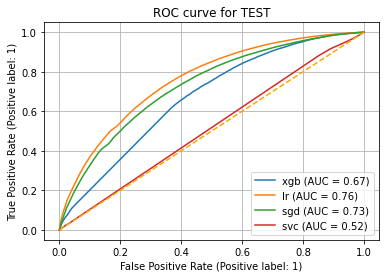

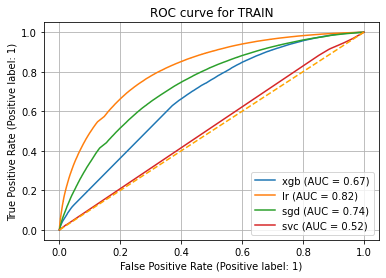

In [137]:
plot_rco_curve(text_results, y_test=y_test, y_pred_name='y_preds_test')
plot_rco_curve(text_results, y_test=y_train, y_pred_name='y_preds_train')

### Conclusion

Logistic regression (LR) seems to significantly outperform other models on the train set and marginally outperform SGD on the test set. As LR is a simpler model, for now, I prefer to continue with it. 

## Embedding selection

In [146]:
from sklearn.feature_extraction.text import CountVectorizer

In [147]:
def count_pipe(X):
    vocabulary = CountVectorizer(
        max_features=MAX_FEATURES, 
        max_df=MAX_DF, 
        ngram_range=NGRAM_RANGE,
        min_df=MIN_DF
    ).fit(X).vocabulary_.keys()    
    return Pipeline([
        ("preprocesser", PreProcessText(
            tokenize=False,
            strip_html=True,
            min_length=0,
            remove_numbers=True,
            remove_url=True,
            to_lower=True
        )),
        ("vectorizer", CountVectorizer(
            max_features=MAX_FEATURES, 
            max_df=MAX_DF, 
            ngram_range=NGRAM_RANGE,
            min_df=MIN_DF,
            vocabulary=vocabulary
        ))
    ])

In [148]:
def tfidf_pipe(X):
    vocabulary = TfidfVectorizer(
        max_features=MAX_FEATURES, 
        max_df=MAX_DF, 
        ngram_range=NGRAM_RANGE,
        min_df=MIN_DF
    ).fit(X).vocabulary_.keys()     
    return Pipeline([
        ("preprocesser", PreProcessText(
            tokenize=False,
            strip_html=True,
            min_length=0,
            remove_numbers=True,
            remove_url=True,
            to_lower=True
        )),
      ("vectorizer", TfidfVectorizer(
            max_features=MAX_FEATURES, 
            max_df=MAX_DF, 
            ngram_range=NGRAM_RANGE,
            min_df=MIN_DF,
            vocabulary=vocabulary
      ))
    ])

In [149]:
def get_pipeline(name, X):
    if name == "tfidf":
        return tfidf_pipe(X)
    else:
        return count_pipe(X)

In [150]:
clf = classifiers['lr']

In [48]:
from sklearn.model_selection import StratifiedKFold

embeddings_results = {}
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=random_state)

for name in ['tfidf', 'count']:
    i=0
    for train_index, test_index in skf.split(df_text, df_target):
        
        names = f"{name.upper()}/FOLD={i}"
        
        print(f"------------ {names} ------------")
        scores = {}
        
        X_train, X_test = df_text.iloc[train_index].sample(frac=0.1, random_state=100), df_text.iloc[test_index].sample(frac=0.1, random_state=100)
        y_train, y_test = df_target.iloc[train_index].sample(frac=0.1, random_state=100), df_target.iloc[test_index].sample(frac=0.1, random_state=100)

        pipe = get_pipeline(name, X_train)
        
        X_train_embeddings = pipe.fit_transform(X_train)
        X_test_embeddings = pipe.fit_transform(X_test)

        clf.fit(X_train_embeddings, y_train)

        scores['y_preds_train'] = clf.predict_proba(X_train_embeddings)
        scores['y_preds_test'] = clf.predict_proba(X_test_embeddings)
        scores['y_train'] = y_train
        scores['y_test'] = y_test

        print(classification_report(y_test, clf.predict(X_test_embeddings)))

        embeddings_results[names] = scores
        i+=1

------------ TFIDF/FOLD=0 ------------
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     13142
           1       0.66      0.68      0.67     13281

    accuracy                           0.66     26423
   macro avg       0.66      0.66      0.66     26423
weighted avg       0.66      0.66      0.66     26423

------------ TFIDF/FOLD=1 ------------
              precision    recall  f1-score   support

           0       0.68      0.66      0.67     13371
           1       0.66      0.68      0.67     13052

    accuracy                           0.67     26423
   macro avg       0.67      0.67      0.67     26423
weighted avg       0.67      0.67      0.67     26423

------------ TFIDF/FOLD=2 ------------
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     13226
           1       0.66      0.67      0.67     13197

    accuracy                           0.66     26423
   macro av

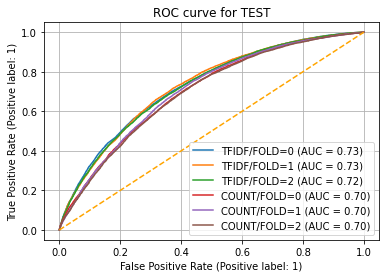

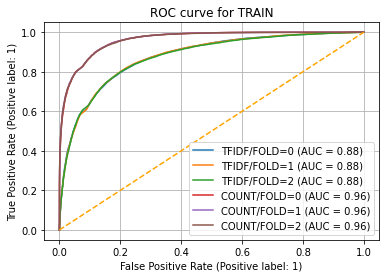

In [49]:
plot_rco_curve(embeddings_results, y_pred_name='y_preds_test', y_test_name='y_test', y_test=None)
plot_rco_curve(embeddings_results, y_pred_name='y_preds_train', y_test_name='y_train', y_test=None)

### Conclusion

The CountVectorizer seems to overfit on the training as the difference with test performance is quite significant. TF-IDF seems to fit slightly better on the test set and is therefore the preferred feature selection algorithm.

## Feature decomposition

In [142]:
from sklearn.decomposition import TruncatedSVD

In [152]:
X_train, X_test, y_train, y_test = train_test_split(
    df_text.fillna('').sample(frac=0.1, random_state=random_state), 
    df_target.sample(frac=0.1, random_state=random_state), 
    test_size=0.20, 
    random_state=random_state
)

In [153]:
def get_decomp_pipe(name, X, n_components):
    pipe = tfidf_pipe(X)
    
    if name == "none":
        return pipe
    elif name == 'svd':
        pipe.steps.append(['svd', TruncatedSVD(n_components=n_components)])
    return pipe

In [1]:
from sklearn.model_selection import StratifiedKFold

decomp_results = {}

for name in ['none', 'svd']:
    for n_components in [10, 100, 300, 500, 1000]:

        scores = {}     
        names = f"{name.upper()}/N_COMP={n_components}" if name != 'none' else f"{name.upper()}"
        
        print(f"------------ {names} ------------")    
        pipe = get_decomp_pipe(name, X_train, n_components)
        
        X_train_embeddings = pipe.fit_transform(X_train)
        X_test_embeddings = pipe.fit_transform(X_test)

        clf.fit(X_train_embeddings, y_train)

        scores['y_preds_train'] = clf.predict_proba(X_train_embeddings)
        scores['y_preds_test'] = clf.predict_proba(X_test_embeddings)
        scores['y_train'] = y_train
        scores['y_test'] = y_test
        
        print(classification_report(y_test, clf.predict(X_test_embeddings)))            

        decomp_results[names] = scores
        
        if name == 'none':
            break

------------ NONE ------------


NameError: name 'get_decomp_pipe' is not defined

In [ ]:
plot_rco_curve(decomp_results, y_pred_name='y_preds_test', y_test_name='y_test', y_test=None)
plot_rco_curve(decomp_results, y_pred_name='y_preds_train', y_test_name='y_train', y_test=None)

## Final text model

### Parameter optimisation 

In [21]:
from sklearn.metrics import roc_auc_score
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.metrics import f1_score

In [160]:
space={
    'preprocesser__remove_punctuation': hp.choice("remove_punctuation", [True, False]),
    'preprocesser__to_lower': hp.choice("to_lower", [True, False]),
    'preprocesser__remove_numbers': hp.choice("remove_numbers", [True, False]),
    'preprocesser__min_length': hp.quniform('min_length', 0, 5, 1),
    'vectorizer__max_features': hp.quniform('max_features', 1000, 200000, 1000), 
    'vectorizer__max_df': hp.uniform('max_df', 0.1, 1), 
    'vectorizer__ngram_range': hp.choice("ngram_range", [(1,1), (1,2), (1,3), (1,4), (1,5)]),
    'vectorizer__stop_words': hp.choice("stop_words", ['english', None]),
    'vectorizer__min_df': hp.quniform('min_df', 1, 5, 1),
    'lr__penalty': hp.choice('penalty', ['l1', 'l2']),
    'lr__C': hp.uniform('C', 0, 2)
}

In [161]:
def objective(space):
    
    X_train_sample = X_train.sample(frac=0.1, random_state=random_state)
    X_test_sample = X_test.sample(frac=0.1, random_state=random_state)
    
    y_train_sample = y_train.sample(frac=0.1, random_state=random_state)
    y_test_sample = y_test.sample(frac=0.1, random_state=random_state)
    
    vocabulary = TfidfVectorizer(
        max_features=int(space['vectorizer__max_features']), 
        max_df=space['vectorizer__max_df'], 
        ngram_range=space['vectorizer__ngram_range'],
        stop_words=space['vectorizer__stop_words'],
        min_df=int(space['vectorizer__min_df']),
        lowercase=space['preprocesser__to_lower']
    ).fit(X_train_sample).vocabulary_.keys()
    
    
    clf = Pipeline([
      ("preprocesser", PreProcessText(
          remove_punctuation=space['preprocesser__remove_punctuation'],
          to_lower=space['preprocesser__to_lower'],
          remove_numbers=space['preprocesser__remove_numbers'],
          min_length=int(space['preprocesser__min_length'])
      )),
      ("vectorizer", TfidfVectorizer(
          max_features=int(space['vectorizer__max_features']), 
          max_df=space['vectorizer__max_df'], 
          ngram_range=space['vectorizer__ngram_range'],
          stop_words=space['vectorizer__stop_words'],
          min_df=int(space['vectorizer__min_df']),
          vocabulary=vocabulary
      )),
      ("lr", LogisticRegression(
          solver='liblinear',
          penalty=space['lr__penalty'],
          C=space['lr__C']
      )),
    ])
    
    clf.fit(X_train_sample, y_train_sample)
    
    pred = clf.predict(X_test_sample)
    auc_score = roc_auc_score(y_test_sample, pred)
    return {'loss': -auc_score, 'status': STATUS_OK }

In [163]:
trials = Trials()

best_params = fmin(
    fn=objective,
    space=space,
    max_evals=100,
    trials=trials,
    algo=tpe.suggest
)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [36:05<00:00, 10.83s/trial, best loss: -0.6670602573548539]


In [192]:
best_params

{'C': 0.9025367736148637,
 'max_df': 0.9202403114186192,
 'max_features': 100000.0,
 'min_df': 1.0,
 'min_length': 1.0,
 'ngram_range': 0,
 'penalty': 1,
 'remove_numbers': 1,
 'remove_punctuation': 1,
 'stop_words': 0,
 'to_lower': 0}

In [194]:
# from hyperopt import space_eval

# params = space_eval(space, best_params)

# with open(repo_path + '/modeling/input/best_params.json', 'w') as fp:
#     json.dump(params, fp)

### Final word model

In [22]:
import json

params = json.load(open(repo_path + '/modeling/input/best_params.json'))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    df_text.fillna(''), 
    df_target, 
    test_size=0.20, 
    random_state=random_state
)

In [29]:
X_text = X_train.progress_apply(clf_preprocess) # Only to get vocabulary

100%|████████████████████████████████| 634147/634147 [00:32<00:00, 19518.58it/s]


In [30]:
vocabulary = TfidfVectorizer(
    max_features=int(params['vectorizer__max_features']), 
    max_df=params['vectorizer__max_df'], 
    ngram_range=params['vectorizer__ngram_range'],
    stop_words=params['vectorizer__stop_words'],
    min_df=int(params['vectorizer__min_df']),
    lowercase=params['preprocesser__to_lower'],
).fit(X_text).vocabulary_.keys()

In [32]:
with open(repo_path + '/modeling/input/vocabulary.json', 'w') as fp:
    json.dump(list(vocabulary), fp)

In [36]:
def get_embeddings_pipeline(params, vocabulary):
    return Pipeline([
      ("preprocesser", PreProcessText(
          remove_punctuation=params['preprocesser__remove_punctuation'],
          to_lower=params['preprocesser__to_lower'],
          remove_numbers=params['preprocesser__remove_numbers'],
          min_length=int(params['preprocesser__min_length']),
          strip_html=True,
          remove_url=True,          
      )),
      ("vectorizer", TfidfVectorizer(
          max_features=int(params['vectorizer__max_features']), 
          max_df=params['vectorizer__max_df'], 
          ngram_range=params['vectorizer__ngram_range'],
          stop_words=params['vectorizer__stop_words'],
          min_df=int(params['vectorizer__min_df']),
          vocabulary=vocabulary
      ))
    ])

In [34]:
clf = LogisticRegression(
    solver='liblinear',
    penalty=params['lr__penalty'],
    C=params['lr__C']
)

#### Model run

In [37]:
embeddings_pipeline = get_embeddings_pipeline(params, vocabulary)

In [38]:
train_embeddings = embeddings_pipeline.fit_transform(X_train)
test_embeddings = embeddings_pipeline.fit_transform(X_test)

In [39]:
clf.fit(train_embeddings, y_train)

LogisticRegression(C=0.9025367736148637, solver='liblinear')

In [170]:
# import pickle

# with open(repo_path + '/modeling/input/lr_model.pkl','wb') as f:
#     pickle.dump(clf, f)

#### Predictions

In [47]:
text = "This is great"

pipe = get_embeddings_pipeline(vocabulary=vocabulary, params=params)
embeddings = pipe.fit_transform(pd.Series([text]))
probs = clf.predict_proba(embeddings)

print(probs)

[[0.26258549 0.73741451]]


#### X-validation

In [54]:
from sklearn.model_selection import StratifiedKFold

i=0
final_results = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)
pipe = get_embeddings_pipeline(params, vocabulary)

for train_index, test_index in skf.split(df_text, df_target):
    
    scores = {}

    X_train, X_test = df_text.iloc[train_index].sample(frac=0.1, random_state=100), df_text.iloc[test_index].sample(frac=0.1, random_state=100)
    y_train, y_test = df_target.iloc[train_index].sample(frac=0.1, random_state=100), df_target.iloc[test_index].sample(frac=0.1, random_state=100)
    
    X_train = pipe.fit_transform(X_train.apply(clf_preprocess))
    X_test = pipe.fit_transform(X_test.apply(clf_preprocess))
    
    clf.fit(X_train, y_train)

    scores['y_preds_train'] = clf.predict_proba(X_train)
    scores['y_preds_test'] = clf.predict_proba(X_test)
    scores['y_train'] = y_train
    scores['y_test'] = y_test
    
    final_results[f"fold={i}"] = scores
    
    i+=1

------------------- FOLD=0 --------------------
------------------- FOLD=1 --------------------
------------------- FOLD=2 --------------------
------------------- FOLD=3 --------------------
------------------- FOLD=4 --------------------
------------------- FOLD=5 --------------------
------------------- FOLD=6 --------------------
------------------- FOLD=7 --------------------
------------------- FOLD=8 --------------------
------------------- FOLD=9 --------------------


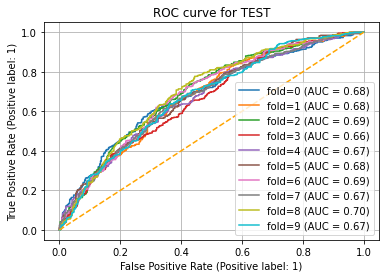

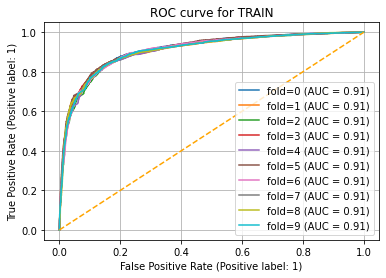

In [55]:
plot_rco_curve(final_results, y_pred_name='y_preds_test', y_test_name='y_test', y_test=None)
plot_rco_curve(final_results, y_pred_name='y_preds_train', y_test_name='y_train', y_test=None)

#### Probs historgram

In [69]:
def plot_probs_historgram(data, title):
    ax = sns.histplot(data=data);
    ax.set_title(title);
    ax.set_xlabel('probs');

In [57]:
X_train, X_test, y_train, y_test = train_test_split(
    df_text.fillna(''), 
    df_target, 
    test_size=0.20, 
    random_state=random_state
)

In [58]:
X_train = pipe.fit_transform(X_train.apply(clf_preprocess))
X_test = pipe.fit_transform(X_test.apply(clf_preprocess))

clf.fit(X_train, y_train)

y_preds_train = clf.predict_proba(X_train)
y_preds_test = clf.predict_proba(X_test)

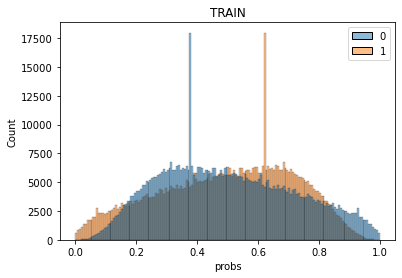

In [70]:
plot_probs_historgram(y_preds_train, "TRAIN")

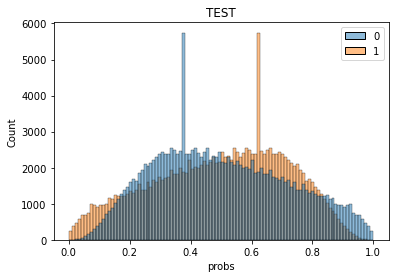

In [71]:
plot_probs_historgram(y_preds_test, "TEST")

#### Final remarks

As both the probs and ROC plots show, the model is able to distinguish reasonably well between positive and negative sentiment, but still some major improvements can (and should) be made. It seems that this approach overfits a bit on the train set. Which does not come as a huge suprise as TF-IDF is highly dependent on the provided vocabulary. Therefore, below, we try to add context features to improve model performance.

## Non-word model
In this approach, we try to fit a seperate model on the text characteristics, irrespective of the actual meaning of the words.

In [77]:
features = [col for col in df_comments.columns if not col.startswith('text') and col != 'label']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(
    df_comments[features], 
    df_comments['label'], 
    test_size=0.20, 
    random_state=random_state
)

In [79]:
pipeline = Pipeline([
  ("scaler", StandardScaler())
])

In [80]:
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.fit_transform(X_test)

In [84]:
context_results = {}

for name, clf in classifiers.items():
    scores = {}
    
    print(name)
    clf.fit(X_train, y_train)
    
    scores['y_preds_train'] = clf.predict_proba(X_train)
    scores['y_preds_test'] = clf.predict_proba(X_test)
    
    context_results[name] = scores

xgb
[23:47:36] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
lr
sgd
svc


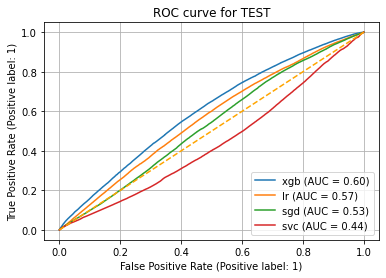

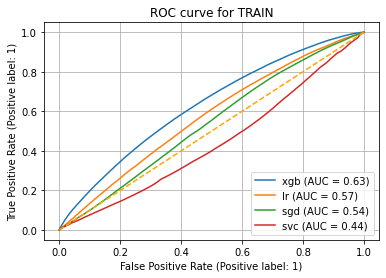

In [86]:
plot_rco_curve(context_results, 'y_preds_test', y_test=y_test, )
plot_rco_curve(context_results, 'y_preds_train', y_test=y_train)

### Parameter optimisation 

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    df_comments[features], 
    df_comments['label'], 
    test_size=0.20, 
    random_state=random_state
)

In [91]:
space={
    'max_depth': hp.quniform("max_depth", 3, 20, 1),
    'gamma': hp.uniform ('gamma', 0, 9),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
    'n_estimators': hp.quniform('min_child_weight', 50, 200, 1),
    'alpha': hp.quniform("alpha", 0, 15, 1),
    'learning_rate': 0.1,
}

In [92]:
def objective(space):
    
    clf = XGBClassifier(
        objective ='binary:logistic', 
        use_label_encoder=False, 
        max_depth = int(space['max_depth']),
        gamma = space['gamma'],
        colsample_bytree=int(space['colsample_bytree']),
        n_estimators =int(space['n_estimators']), 
        alpha = space['alpha'],
        learning_rate = space['learning_rate']
        
    )
    clf.fit(
        X_train.sample(frac=0.1, random_state=random_state), 
        y_train.sample(frac=0.1, random_state=random_state)
    )
    
    pred = clf.predict(X_test.sample(frac=0.1, random_state=random_state))
    auc_score = roc_auc_score(y_test.sample(frac=0.1, random_state=random_state), pred)
    
    print ("SCORE:", auc_score)
    return {'loss': -auc_score, 'status': STATUS_OK }

In [93]:
trials = Trials()

best_hyperparams = fmin(
    fn=objective,
    space=space,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials
)

[23:54:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.572908519355866                                                               
[23:54:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5701207415844716                                                              
[23:54:19] WARNING: /Users/runner/miniforg

[23:54:49] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5683507810413606                                                              
[23:54:50] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5714494055669522                                                              
[23:54:51] WARNING: /Users/runner/miniforg

[23:55:23] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.57375262365721                                                                
[23:55:27] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5715089013094617                                                              
[23:55:30] WARNING: /Users/runner/miniforg

[23:56:03] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5715337276725257                                                              
[23:56:06] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5743248474543327                                                              
[23:56:10] WARNING: /Users/runner/miniforg

[23:56:45] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5736955150649952                                                              
[23:56:48] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5746822993394485                                                              
[23:56:50] WARNING: /Users/runner/miniforg

[23:57:26] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5751431705324948                                                              
[23:57:30] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
SCORE:                                                                          
0.5740087489694871                                                              
[23:57:33] WARNING: /Users/runner/miniforg

In [115]:
from hyperopt import space_eval

params = space_eval(space, best_hyperparams)
params['colsample_bytree'] = int(params['colsample_bytree'])
params['max_depth'] = int(params['max_depth'])
params['n_estimators'] = int(params['n_estimators'])
params

{'alpha': 4.0,
 'colsample_bytree': 0,
 'gamma': 3.269197325207647,
 'learning_rate': 0.1,
 'max_depth': 3,
 'n_estimators': 200}

### Evaluation & X-validation

In [116]:
clf = XGBClassifier(
    objective ='binary:logistic', 
    use_label_encoder=False, 
    **params
)

In [117]:
from sklearn.model_selection import StratifiedKFold

final_results = {}
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=random_state)

for train_index, test_index in skf.split(df_text, df_target):
    
    scores = {}

    X_train, X_test = (
        df_comments[features].iloc[train_index].sample(frac=0.1, random_state=100), 
        df_comments[features].iloc[test_index].sample(frac=0.1, random_state=100)
    )
    y_train, y_test = (
        df_target.iloc[train_index].sample(frac=0.1, random_state=100), 
        df_target.iloc[test_index].sample(frac=0.1, random_state=100)
    )
    
    X_train = pipeline.fit_transform(X_train)
    X_test = pipeline.fit_transform(X_test)
    
    clf.fit(X_train, y_train)

    scores['y_preds_train'] = clf.predict_proba(X_train)
    scores['y_preds_test'] = clf.predict_proba(X_test)
    scores['y_train'] = y_train
    scores['y_test'] = y_test
    
    final_results[f"fold={i}"] = scores
    
    i+=1

[00:13:14] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:16] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:18] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426408905/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:13:20] WARNING: /Users/runner/miniforge3/cond

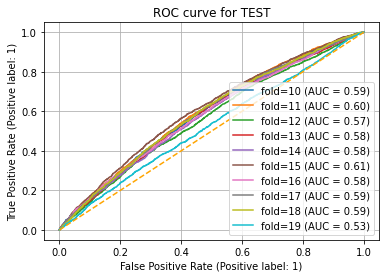

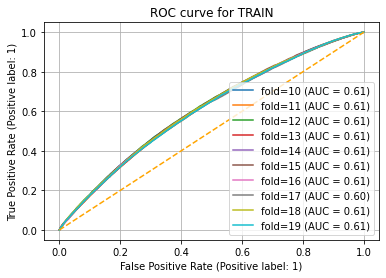

In [118]:
plot_rco_curve(final_results, y_pred_name='y_preds_test', y_test_name='y_test', y_test=None)
plot_rco_curve(final_results, y_pred_name='y_preds_train', y_test_name='y_train', y_test=None)

### Conclusion

Based on the characteristics of the text, it is hard to distinguish between positive and negative sentiment. As a model by itself, it performance significantly worse than the text model (which is to be expected obviously). Though, out of curiosity, I'm curious whether this "weak learner" may be able to improve the text model by stacking them together.

## Ensemble model

In [138]:
import numpy as np

In [139]:
casa = {}
for alpha in np.arange(0, 1, 0.1):
    preds = {}
    for y_pred_name in ['y_preds_train', 'y_preds_test']:
        preds[y_pred_name] = alpha * context_results['xgb'][y_pred_name] + (1-alpha) * text_results['lr'][y_pred_name]
        
    casa[f'alpha_{alpha:.2f}'] = preds

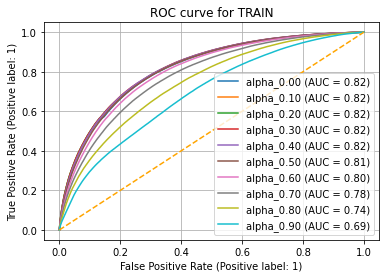

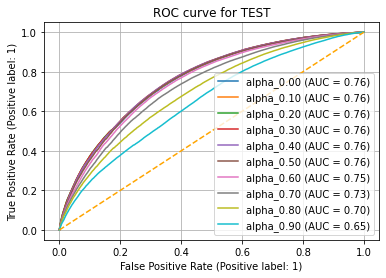

In [140]:
plot_rco_curve(casa, 'y_preds_train', y_test=y_train)
plot_rco_curve(casa, 'y_preds_test', y_test=y_test)

## Final conclusion

As kidna expected, but still a bit sad, the ensemble model is not able to perform signicantly better than the text model by its own. Therefore, we will use the final text model to predict the probability a text has positive sentiment. 